# Data Loading + Augmentation

In [1]:
from main_dino import DataAugmentationDINO
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import utils
import json
import os
import time
import datetime
from pathlib import Path
import math
import sys
import config

In [16]:
transform = DataAugmentationDINO(
    config.global_crops_scale,
    config.local_crops_scale,
    config.local_crops_number
)

dataset = datasets.ImageFolder(config.datapath, transform=transform)
# sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
data_loader = torch.utils.data.DataLoader(
    dataset,
    # sampler=sampler,
    batch_size=64,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)
print(f"Data loaded: there are {len(dataset)} images.")

Data loaded: there are 1130319 images.


In [17]:
def plot_img(dataset, index):
    img, label = dataset[index]
    
    # Number of images to plot
    num_images = len(img)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    if num_images == 1:
        axes = [axes] 
    
    titles = [f"Global Crop {i+1}" for i in range(min(2, num_images))]
    titles.extend([f"Local Crop {i-1}" for i in range(2, num_images)])
    
    for i, curr_img in enumerate(img):
        inv_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        
        # Undo normalization
        img_denorm = inv_normalize(curr_img)
        
        img_reshaped = img_denorm.permute(1, 2, 0).numpy()
        img_reshaped = (img_reshaped - img_reshaped.min()) / (img_reshaped.max() - img_reshaped.min())  # Rescale to [0, 1]
        
        axes[i].imshow(img_reshaped)
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


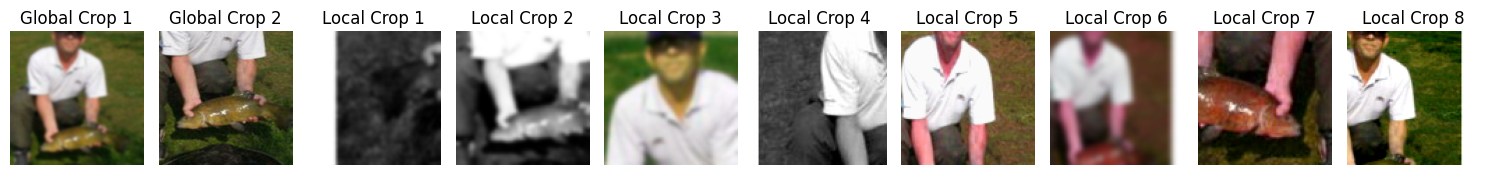

In [18]:
plot_img(dataset, 0)    

# DINO

In [19]:
from main_dino import DINOLoss
from utils import MultiCropWrapper
from vision_transformer import DINOHead, vit_small, vit_tiny, vit_base
import vision_transformer

In [20]:
# student = vision_transformer.__dict__["vit_small"](patch_size, drop_path_rate)
# student

In [21]:
class Dino():
    def __init__(self, architecture="vit_tiny"):
        self.student = vision_transformer.__dict__[architecture](config.patch_size) #, drop_path_rate)
        self.teacher = vision_transformer.__dict__[architecture](config.patch_size)

        embed_dim = self.student.embed_dim
        self.student = MultiCropWrapper(self.student, DINOHead(embed_dim, config.out_dim, config.use_bn_in_head, config.norm_last_layer))
        self.teacher = MultiCropWrapper(self.teacher, DINOHead(embed_dim, config.out_dim, config.use_bn_in_head))
                                    
        # move networks to gpu
        if torch.cuda.is_available():
            self.student, self.teacher = self.student.cuda(), self.teacher.cuda()
        print(f"using cuda: {torch.cuda.is_available()}")

        self.teacher_without_ddp = self.teacher
        # teacher and student start with the same weights
        self.teacher_without_ddp.load_state_dict(self.student.state_dict())
        # there is no backpropagation through the teacher, so no need for gradients
        for p in self.teacher.parameters():
            p.requires_grad = False
        print(f"Student and Teacher are built: they are both {architecture} network.")


In [22]:
dino = Dino("vit_tiny")
dino

using cuda: False
Student and Teacher are built: they are both vit_tiny network.


In [23]:
# loss
if torch.cuda.is_available():
    dino_loss = DINOLoss(
        config.out_dim,
        config.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        config.warmup_teacher_temp,
        config.teacher_temp,
        config.warmup_teacher_temp_epochs,
        config.epochs,
    ).cuda()
else:
    print("no cuda available")
    dino_loss = DINOLoss(
        config.out_dim,
        config.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        config.warmup_teacher_temp,
        config.teacher_temp,
        config.warmup_teacher_temp_epochs,
        config.epochs,
    )

# optimizer
params_groups = utils.get_params_groups(dino.student)
optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs

# schedulers
lr_schedule = utils.cosine_scheduler(
    config.lr * (config.batch_size_per_gpu * utils.get_world_size()) / 256.,  # linear scaling rule
    config.min_lr,
    config.epochs, len(data_loader),
    warmup_epochs=config.warmup_epochs,
)
wd_schedule = utils.cosine_scheduler(
    config.weight_decay,
    config.weight_decay_end,
    config.epochs, len(data_loader),
)
# momentum parameter is increased to 1. during training with a cosine schedule
momentum_schedule = utils.cosine_scheduler(config.momentum_teacher, 1,
                                            config.epochs, len(data_loader))
print(f"Loss, optimizer and schedulers ready.")

no cuda available
Loss, optimizer and schedulers ready.


# Training

In [24]:
def train_one_epoch(student, teacher, teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr_schedule, wd_schedule, momentum_schedule, epoch):
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Epoch: [{}/{}]'.format(epoch, config.epochs)
    
    for it, (images, _) in enumerate(metric_logger.log_every(data_loader, 10, header)):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        if torch.cuda.is_available():
            images = [im.cuda(non_blocking=True) for im in images]
        else:
            print("cuda not available")
        
        # teacher and student forward passes + compute dino loss
        teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
        student_output = student(images)
        loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        loss.backward()
        if config.clip_grad:
            param_norms = utils.clip_gradients(student, config.clip_grad)
        utils.cancel_gradients_last_layer(epoch, student, config.freeze_last_layer)
        optimizer.step()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.parameters(), teacher_without_ddp.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        # torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    
    # Print averaged stats
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [25]:
print("Starting DINO training !")

start_time = time.time()

for epoch in range(0, config.epochs):
    # Training one epoch of DINO
    train_stats = train_one_epoch(
        dino.student, dino.teacher, dino.teacher_without_ddp, dino_loss,
        data_loader, optimizer, lr_schedule, wd_schedule, momentum_schedule,
        epoch
    )

    # Writing logs
    save_dict = {
        'student': dino.student.state_dict(),
        'teacher': dino.teacher.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch + 1,
        'dino_loss': dino_loss.state_dict(),
    }
    
    # Save checkpoint
    checkpoint_path = os.path.join(config.output_dir, 'checkpoint.pth')
    torch.save(save_dict, checkpoint_path)
    
    if config.saveckp_freq and epoch % config.saveckp_freq == 0:
        checkpoint_path = os.path.join(config.output_dir, f'checkpoint{epoch:04}.pth')
        torch.save(save_dict, checkpoint_path)
    
    # Logging statistics
    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()}, 'epoch': epoch}
    
    # Always perform logging
    log_path = Path(config.output_dir) / "log.txt"
    with log_path.open("a") as f:
        f.write(json.dumps(log_stats) + "\n")

# Print total training time
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))


Starting DINO training !
cuda not available
Epoch: [0/100]  [    0/17661]  eta: 3 days, 1:07:16  loss: 10.720951 (10.720951)  lr: 0.000000 (0.000000)  wd: 0.040000 (0.040000)  time: 14.904988  data: 6.332408
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
Epoch: [0/100]  [   10/17661]  eta: 1 day, 18:50:03  loss: 10.840344 (10.858995)  lr: 0.000000 (0.000000)  wd: 0.040000 (0.040000)  time: 8.736244  data: 0.577718
cuda not available
cuda not available
cuda not available
cuda not available
cuda not available
